In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# directory that contains .wav files to process
NUM_EPOCHS = 1
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 2000)

Reading in .wav files...


In [5]:
s = np.array([[-2, 2], [-3, 4], [-12, 6]]).astype('float32')

mn = np.min(s, axis = 1)
mx = np.max(s, axis = 1)

maxabs = np.maximum(np.abs(mn), np.abs(mx))

for i in xrange(0, s.shape[0]):
    s[i] /= maxabs[i]

print s

[[-1.    1.  ]
 [-0.75  1.  ]
 [-1.    0.5 ]]


In [6]:
# waveform preprocessing
def preprocessWaveform(waveform):   
    return waveform, ()
   
def unpreprocessWaveform(waveform, params):
    return waveform



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
   
    mn = np.min(processed, axis = 1)
    mx = np.max(processed, axis = 1)

    maxabs = np.maximum(np.abs(mn), np.abs(mx))

    for i in xrange(0, processed.shape[0]):
        processed[i] /= maxabs[i]
    processed *= 0.98
   
    #processed = (processed + 1.0) / 2.0
   
    return processed, (maxabs,)

def unpreprocessWindows(windows, params):
    # scale window from [-1, 1] to [-32768, 32768]
    scl = params[0]
   
    unprocessed = np.copy(windows)
    unprocessed /= 0.98
   
    #nprocessed = (unprocessed * 2.0) - 1.0
   
    for i in xrange(0, unprocessed.shape[0]):
        unprocessed[i] *= scl[i]

    return unprocessed

In [7]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(processedWaveforms[i])

In [8]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (203086, 512)
Max:  17885.0
Min:  -17139.0


In [9]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (203086, 512)


In [10]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [11]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [12]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(203086, 512, 1)
0.0184928
0.28096
-0.98
0.98


In [13]:
# operations for binarization layer (THEANO ONLY)

class Binarize(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(Binarize, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        # TODO: learn threshold per parameter?
        z[0] = np.copy(x)
        z[0][z[0] < 0] = -1
        z[0][z[0] >= 0] = 1
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        # (i don't think there's a mathematical justification for this?)
        return [output_gradients[0]]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

    
class BinarizeLayer(Layer):
    """ Binarizes input 
    <feedforward> binarizes output of tanh to -1 and 1
    <backward> returns delta unchanged
    """
    def __init__(self, **kwargs):
        super(BinarizeLayer, self).__init__(**kwargs)
        self.op = Binarize()
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        return self.op(x)

    #def get_output_shape_for(self, input_shape):
    #    return input_shape
    
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(BinarizeLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [14]:
# verify Binarize op works
x = T.matrix()
f = theano.function([x], Binarize()(x))
inp = np.random.uniform(high = 1, low = -1, size = (6, 6)).astype('float32')
out = f(inp)

print(inp)
print(out)

[[ 0.33562362  0.70800918 -0.45822293  0.97265851 -0.90558368 -0.04970991]
 [ 0.2467512   0.95000362 -0.07283129 -0.57688671 -0.81897026 -0.55547291]
 [ 0.56578547  0.60103834  0.27596629 -0.21553239  0.42781109  0.67913371]
 [ 0.3511824  -0.78730786  0.11396207 -0.83441663 -0.26810172  0.28188729]
 [ 0.66800201 -0.26689175 -0.45890701 -0.97610581 -0.62344414  0.40166906]
 [ 0.96138102  0.81705546  0.84159112 -0.7941559   0.1064133  -0.62916756]]
[[ 1.  1. -1.  1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1.]
 [ 1.  1.  1. -1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1.]]


In [15]:
# operations for binarization layer (THEANO ONLY)

class StochasticBinarize(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(StochasticBinarize, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        prob_thresh = (x + 1.0) / 2.0
        probs = np.random.random_sample(x.shape)
        res = np.greater(probs, prob_thresh)
        res = res.astype('float32') * 2.0 - 1.0
        res = -res
        
        # TODO: learn threshold per parameter?
        z[0] = np.copy(res)
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged (since expected value
        # is just x)
        return [output_gradients[0]]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

    
class StochasticBinarizeLayer(Layer):
    """ Binarizes input 
    <feedforward> binarizes output of tanh to -1 and 1
    <backward> returns delta unchanged
    """
    def __init__(self, **kwargs):
        super(StochasticBinarizeLayer, self).__init__(**kwargs)
        self.stc_op = StochasticBinarize()
        self.det_op = Binarize()
        self.uses_learning_phase = True
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        x = K.in_train_phase(self.stc_op(x), self.det_op(x))
        return x
    
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(StochasticBinarizeLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [16]:
# verify Binarize op works
x = T.matrix()
f = theano.function([x], StochasticBinarize()(x))
inp = np.random.uniform(high = 1, low = -1, size = (6, 6)).astype('float32')

iters = 10000
out = None
for i in xrange(0, iters):
    if (out is None):
        out = f(inp)
    else:
        out += f(inp)
out /= float(iters)

print(inp)
print(f(inp))
print(out)

[[-0.24983543 -0.32169777 -0.45486018 -0.53458315 -0.54013187  0.43364781]
 [ 0.29341388  0.0680304   0.76498973 -0.26087928  0.81113625  0.9299885 ]
 [ 0.28663173  0.83730376  0.21503422 -0.46073043 -0.91623557 -0.34287804]
 [ 0.89866322  0.66785192  0.75798982 -0.26086125  0.44924948  0.61334175]
 [ 0.73828876 -0.15296386 -0.6308285  -0.47280049  0.16119671 -0.39564225]
 [-0.50515342  0.88961512  0.795968   -0.29680789  0.16047063  0.02705537]]
[[-1. -1. -1. -1. -1.  1.]
 [-1.  1.  1. -1.  1.  1.]
 [ 1.  1. -1.  1. -1.  1.]
 [ 1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1. -1.  1.  1.]]
[[-0.24860001 -0.32659999 -0.46439999 -0.53140002 -0.54119998  0.44859999]
 [ 0.27860001  0.0698      0.75980002 -0.25920001  0.82059997  0.92979997]
 [ 0.29960001  0.83719999  0.20900001 -0.45879999 -0.9188     -0.324     ]
 [ 0.8962      0.6742      0.75379997 -0.2626      0.44440001  0.62      ]
 [ 0.7396     -0.142      -0.634      -0.47639999  0.1558     -0.38159999]
 [-0.484600

In [17]:
from scipy.fftpack import dct as scidct

# ====================================================================
#  DCT (Discrete Cosine Transform)
# ====================================================================

# generate square dct matrix
#     how to use: generate n-by-n matrix M. then, if you have a signal w, then:
#                 dct(w) = M * w
#     where w must be n-by-1
#
#     backed by scipy
def generate_dct_mat(n, norm = 'ortho'):
    return (scidct(np.eye(n), norm = norm))

# DCT matrix is precomputed at start of program
dctMat = generate_dct_mat(WINDOW_SIZE)
th_dctMat = K.variable(dctMat)

# given a (symbolic Theano) array of size M x WINDOW_SIZE
#     this returns an array M x WINDOW_SIZE where every one of the M samples has been independently
#     filtered by the DCT
def theano_dct(x, dctMat = None):
    global th_dctMat
    
    if (dctMat is None):
        dctMat = th_dctMat
        
    # reshape x into 2D array, and perform appropriate matrix operation
    reshaped_x = x.reshape((1, x.shape[0], x.shape[1]))

    result = T.tensordot(dctMat, reshaped_x, [[0], [2]])
    result = result.reshape((result.shape[0], result.shape[2])).T

    return result

# M x WINDOW_SIZE x 1 => M x WINDOW_SIZE x 1
def theano_batch_dct(x):
    result = theano_dct(x)
    reshaped_result = result.reshape((result.shape[0], result.shape[1], 1))

    return reshaped_result

In [18]:
class PhaseShift1D(Layer):
    """ PhaseShift1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShift1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(PhaseShift1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
# test phase shift operation from Shi et al. (2016) in 1D
batch = []

for i in xrange(0, 2):
    n4 = []

    for j in xrange(0, 8):
        filt = []
        for k in xrange(0, 8):
            filt.append(i * 32 + j * 8 + k)
        n4.append(filt)
        
    batch.append(n4)
    
batch = K.variable(np.array(batch))
print batch.shape.eval()
print batch.eval()

n = 2
x = T.reshape(batch, (batch.shape[0], batch.shape[1], batch.shape[2] / n, n))
x = T.transpose(x, (0, 1, 3, 2))
x = T.reshape(x, (batch.shape[0], batch.shape[1] * n, batch.shape[2] / n))
print x.shape.eval()
print x.eval()

[2 8 8]
CudaNdarray([[[  0.   1.   2.   3.   4.   5.   6.   7.]
  [  8.   9.  10.  11.  12.  13.  14.  15.]
  [ 16.  17.  18.  19.  20.  21.  22.  23.]
  [ 24.  25.  26.  27.  28.  29.  30.  31.]
  [ 32.  33.  34.  35.  36.  37.  38.  39.]
  [ 40.  41.  42.  43.  44.  45.  46.  47.]
  [ 48.  49.  50.  51.  52.  53.  54.  55.]
  [ 56.  57.  58.  59.  60.  61.  62.  63.]]

 [[ 32.  33.  34.  35.  36.  37.  38.  39.]
  [ 40.  41.  42.  43.  44.  45.  46.  47.]
  [ 48.  49.  50.  51.  52.  53.  54.  55.]
  [ 56.  57.  58.  59.  60.  61.  62.  63.]
  [ 64.  65.  66.  67.  68.  69.  70.  71.]
  [ 72.  73.  74.  75.  76.  77.  78.  79.]
  [ 80.  81.  82.  83.  84.  85.  86.  87.]
  [ 88.  89.  90.  91.  92.  93.  94.  95.]]])
[ 2 16  4]
[[[  0.   2.   4.   6.]
  [  1.   3.   5.   7.]
  [  8.  10.  12.  14.]
  [  9.  11.  13.  15.]
  [ 16.  18.  20.  22.]
  [ 17.  19.  21.  23.]
  [ 24.  26.  28.  30.]
  [ 25.  27.  29.  31.]
  [ 32.  34.  36.  38.]
  [ 33.  35.  37.  39.]
  [ 40.  42.  44.  4

In [20]:
# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# we generate a new optimizer of the same kind for every model
# we train
def opti():
    return Adam()

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 64

# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc = Sequential()
    dec = Sequential()
    
    enc.add(GaussianDropout(0.05, input_shape = dim))
    
    # (512x1) => (256x256)
    enc.add(Convolution1D(256, 9, border_mode = 'same',
                          input_shape = dim, activation = 'linear',
                          bias = True))
    enc.add(LeakyReLU(0.2))
    enc.add(MaxPooling1D(2))
    
    # (256x256) => (256x128)
    enc.add(Convolution1D(128, 9, border_mode = 'same',
                          input_shape = dim, activation = 'linear',
                          bias = True))
    enc.add(LeakyReLU(0.2))
    
    # (256x128) => (128x128)
    enc.add(Convolution1D(128, 9, border_mode = 'same',
                          input_shape = dim, activation = 'linear',
                          bias = True))
    enc.add(LeakyReLU(0.2))
    enc.add(MaxPooling1D(2))
    
    # (128x128) => (128x64) [5]
    enc.add(Convolution1D(64, 9, border_mode = 'same',
                          input_shape = dim, activation = 'linear',
                          bias = True))
    enc.add(LeakyReLU(0.2))
    
    # (128x64) => (64x64) [5]
    enc.add(Convolution1D(64, 9, border_mode = 'same',
                          input_shape = dim, activation = 'linear',
                          bias = True))
    enc.add(LeakyReLU(0.2))
    enc.add(MaxPooling1D(2))
    
    # (64x64) => (64x32) [5]
    enc.add(Convolution1D(32, 9, border_mode = 'same',
                          input_shape = dim, activation = 'linear',
                          bias = True))
    enc.add(LeakyReLU(0.2))
    
    # (32x16) => (32x1) [3]
    enc.add(Convolution1D(1, 9, border_mode = 'same',
                          activation = 'tanh',
                          bias = True))
    
    # dense-encode and binarize
    enc.add(Flatten())
    enc.add(Dense(64, activation = 'tanh', init = 'identity'))
    enc.add(Reshape((bottleneck_size,)))
    
    
    dec.add(Dense(64, activation = 'tanh', init = 'identity',
                  input_shape = (bottleneck_size,)))
    dec.add(Reshape((64, 1,)))
    
    # (64x1) => (64x32)
    dec.add(Convolution1D(32, 9, border_mode = 'same',
                          activation = 'linear',
                          bias = True))
    dec.add(LeakyReLU(0.2))
    
    
    # (64x32) => (64x64)
    dec.add(Convolution1D(64, 9, border_mode = 'same',
                          activation = 'linear',
                          bias = True))
    dec.add(LeakyReLU(0.2))
    
    # (64x64 => 128x64)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(64 * 1, 9, border_mode = 'same',
                          activation = 'linear',
                          bias = True))
    dec.add(LeakyReLU(0.2))
    #dec.add(PhaseShift1D(2))
    
    # (128x128 => 256x128)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(128 * 1, 9, border_mode = 'same',
                          activation = 'linear',
                          bias = True))
    dec.add(LeakyReLU(0.2))
    #dec.add(PhaseShift1D(2))
    
    # (256x256 => 512x256)
    dec.add(UpSampling1D(2))
    dec.add(Convolution1D(256 * 1, 9, border_mode = 'same',
                          activation = 'linear',
                          bias = True))
    dec.add(LeakyReLU(0.2))
    #dec.add(PhaseShift1D(2))
 
    # (512x32) => (512x1)
    dec.add(Convolution1D(1, 9, border_mode = 'same',
                          activation = 'linear',
                          bias = True))
    dec.add(Activation('tanh'))
    
    return enc, dec


# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    dsc = Sequential()
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.2))
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.2))

    dsc.add(Convolution1D(48, 5, border_mode='valid', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.2))
    
    dsc.add(Convolution1D(48, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.2))
    
    dsc.add(Convolution1D(48, 5, border_mode='valid', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.2))
    
    dsc.add(Flatten())
    
    dsc.add(Dense(128, activation = 'linear'))
    dsc.add(LeakyReLU(0.2))
    dsc.add(Dense(1, activation = 'sigmoid'))
    
    return dsc


# plain autoencoder
plain_input = Input(shape = input_dim)
plain_enc, plain_dec = autoencoder_structure(input_dim)
plain_embedding = plain_enc(plain_input)
plain_reconstructed = plain_dec(plain_embedding)
plain_autoencoder = Model(input = [plain_input], output = [plain_reconstructed])
plain_autoencoder.compile(loss = 'mean_squared_error', optimizer = opti())

# construct autoencoder to be used in adversarial training (AAC - Adversarial AutoenCoder)
# uhhhh... whoops i screwed up the acronym
aac_input = Input(shape = input_dim)
aac_enc, aac_dec = autoencoder_structure(input_dim)
aac_embedding = aac_enc(aac_input)
aac_reconstructed = aac_dec(aac_embedding)

aac_autoencoder = Model(input = [aac_input], output = [aac_reconstructed])
aac_autoencoder.compile(loss = 'mean_squared_error', optimizer = opti())



# construct discriminator 1: fft-based
'''
fft_transform = Lambda(theano_batch_dft,
                       output_shape = lambda x : (x[0], x[1] * 2, 1))

fftdsc_input_dim = (WINDOW_SIZE * 2, 1)
fftdsc_input = Input(shape = input_dim)
fftdsc_struct = discriminator_structure(fftdsc_input_dim)

fftdsc_label = fftdsc_struct(fft_transform(fftdsc_input))
aac_fft_label = fftdsc_struct(fft_transform(aac_reconstructed))
'''


# construct discriminator 2: regular
'''
regdsc_input_dim = (WINDOW_SIZE, 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(regdsc_input)
aac_reg_label = regdsc_struct(aac_reconstructed)
'''


'''
nlvls = 8
haar_transform = Lambda(lambda x: haar_multilevel(x, nlvls, True),
                        output_shape = lambda x : (x[0], x[1], nlvls + 1))
regdsc_input_dim = (WINDOW_SIZE, nlvls + 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(haar_transform(regdsc_input))
aac_reg_label = regdsc_struct(haar_transform(aac_reconstructed))
'''

dct_transform = Lambda(theano_batch_dct,
                       output_shape = lambda x : (x[0], x[1], 1))
regdsc_input_dim = (WINDOW_SIZE, 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(dct_transform(regdsc_input))
aac_reg_label = regdsc_struct(dct_transform(aac_reconstructed))





def upper_dct_loss(y_true, y_pred):
    dct_true = theano_batch_dct(y_true)
    dct_pred = theano_batch_dct(y_pred)
    cutoff_idx = WINDOW_SIZE / 4
    
    # compute MSE in frequency domain
    error = T.mean(T.sqr(dct_pred[:, cutoff_idx:] - dct_true[:, cutoff_idx:]), axis = 1)
    return error


# compile model
loss_weights = [350.0, 300.0, 1.0]
ndiscrim = 1
lmult = len(loss_weights) - ndiscrim


make_trainable(aac_autoencoder, False)

aac_discrim_reg = Model(input = [regdsc_input], output = [regdsc_label])
aac_discrim_reg.compile(loss = ['binary_crossentropy'], optimizer = opti())
aac_discrim_reg.summary()

aac_autoencoder.summary()

make_trainable(aac_discrim_reg, False)
make_trainable(aac_autoencoder, True)
model = Model(input = [aac_input], output = [aac_reconstructed] * lmult + [aac_reg_label])
model.compile(loss = ['mean_squared_error', upper_dct_loss, 'binary_crossentropy'],
              loss_weights = loss_weights,
              optimizer = opti())
model.summary()

X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 512, 1)        0           input_3[0][0]                    
____________________________________________________________________________________________________
sequential_5 (Sequential)        (None, 1)             421601      lambda_1[0][0]                   
Total params: 421601
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Con

In [21]:
'''
plain_autoencoder.fit(X_train, X_train, batch_size = 128, nb_epoch = 3)

lead = ""
startTime = time.time()
print lead + "Evaluating..."
metrics = autoencoderTest("./SA1.WAV", "SA1_reg_eval_", plain_autoencoder, verbose = False)

print lead + "Max/min desired:", metrics[0], metrics[1]
print lead + "Max/min recons: ", metrics[2], metrics[3]
print lead + "MSE:     ", metrics[4]
print lead + "Avg err: ", metrics[5]

elapsed = time.time() - startTime
print lead + "Total time for evaluation: " + str(elapsed) + "s"
'''
0

0

In [22]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [23]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    #sciwav.write(prefix + "desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    
    sciwav.write(prefix + "output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [24]:
# interleave two numpy arrays of the same size along the first axis
def interleave(a, b):    
    r = np.empty(a.shape)
    r = np.repeat(r, 2, axis = 0)
    
    r[::2] = a
    r[1::2] = b
    return r

In [25]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 10

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))


for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # train autoencoder, if discriminator accuracy is greater than 70%
        if (epoch > 0):
            make_trainable(aac_autoencoder, True)
            make_trainable(aac_discrim_reg, False)
            
            a_y = [batch] * lmult + [np.ones(nbatch)] * ndiscrim
            a_losses = model.train_on_batch(batch, a_y)
        
        # train discriminator(s) on what the autoencoder now generates
        generated = aac_autoencoder.predict(batch)
        discrim_batch_X = interleave(batch, generated)
        discrim_batch_y = interleave(np.ones(nbatch), np.zeros(nbatch))
        
        make_trainable(aac_autoencoder, False)
        make_trainable(aac_discrim_reg, True)
        d_loss = aac_discrim_reg.train_on_batch(discrim_batch_X, discrim_batch_y)
        
        if (epoch == 0 and d_loss < 0.2):
            print ""
            print lead + "Terminating epoch early (don't wanna overfit!)"
            break
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_arr) > 1):
                for i in xrange(0, len(loss_weights)):
                    loss_arr[i + 1] *= loss_weights[i]
                print loss_arr,
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"

    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
    d_X = np.concatenate((X_train[rows, :], generated))
    d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
    d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                               d_X, d_y, verbose = False)

    print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_nonres_train_epoch" + str(epoch+1), aac_autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
        
    print ""

Epoch 1:
    1280: 0.337589919567  ['autoencoder not training'] 
    Terminating epoch early (don't wanna overfit!)

    Total time for epoch: 12.8346378803s
    ----------------
    Evaluated the discriminator: 100.0% d_acc
    Total time for evaluation: 1.43146514893s
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  7.95375e-08 -3.14321e-08
    MSE:      154618.0
    Avg err:  210.222
    Total time for evaluation: 0.251217126846s

Epoch 2:
    1280: 0.491309046745  [12.816845 0.018464 0.015059 1.836775] [12.816845 6.462516 4.517554 1.836775] 
    Total time for epoch: 1610.8296051s
    ----------------
    Evaluated the discriminator: 80.0% d_acc
    Total time for evaluation: 0.468273878098s
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  3708.25 -2761.67
    MSE:      17718.8
    Avg err:  69.747
    Total time for evaluation: 0.252481937408s

Epoch 3:
    1280: 0

KeyboardInterrupt: 

In [26]:
enc = model.layers[1].layers
dec = model.layers[2].layers


In [27]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 89.0% d_acc


In [28]:
autoencoderTest("./SA1.WAV", "SA1_aac_", aac_autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_", aac_autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_", aac_autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4425.96 -2792.75
./SA1.WAV  mse:  16127.1
./SA1.WAV  avg err:  68.8939
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  2755.95 -2428.49
./SX383.WAV  mse:  8877.5
./SX383.WAV  avg err:  52.6184
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  19493.1 -12632.2
./fiveYears.wav  mse:  4.97808e+06
./fiveYears.wav  avg err:  1585.14


[24636.0, -20122.0, 19493.061, -12632.202, 4978084.5, 1585.136]

In [29]:
[rate, data] = sciwav.read("./SA1.WAV")
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)


# first, write desired reconstruction
transformed, tparams = preprocessWindows(windows)
print transformed.shape
desired = unpreprocessWindows(transformed, tparams)

# then, run NN on transformed windows
transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
autoencOutput = aac_autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)
print autoencOutput.shape
autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))

print autoencOutput.shape
recons = unpreprocessWindows(autoencOutput, tparams)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)


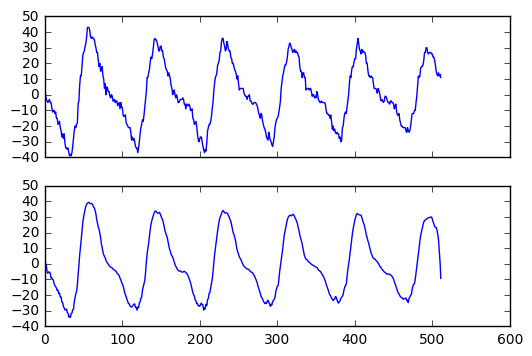

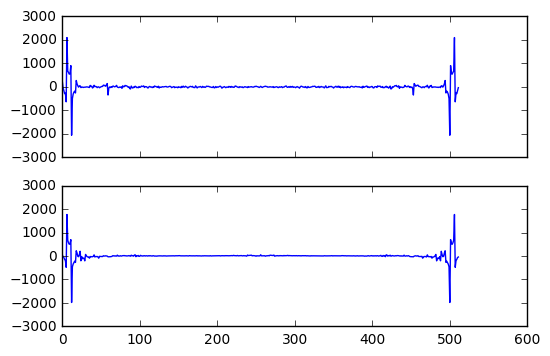

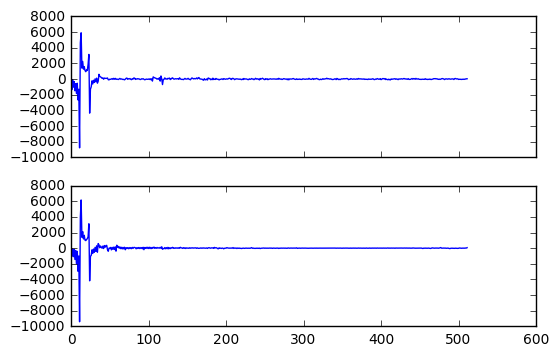

In [30]:
from numpy.fft import fft

%matplotlib inline
x = np.arange(0, desired.shape[1])
idx = 23

# 45 is a high-freq thingy
# 67 is a vowel

desired_fft = fft(desired[idx])
recons_fft = fft(recons[idx])

desired_dct = scidct(desired[idx])
recons_dct = scidct(recons[idx])

'''
desired_haar = desired[idx].reshape((1, WINDOW_SIZE, 1))
desired_haar = haar_multilevel(desired_haar, 8)
recons_haar = recons[idx].reshape((1, WINDOW_SIZE, 1))
recons_haar = haar_multilevel(recons_haar, 8)
print desired_haar[:, :4, :].eval()
print recons_haar[:, :4, :].eval()
'''

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(x, desired[idx])
ax2.plot(x, recons[idx])

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(x, desired_fft)
ax2.plot(x, recons_fft)

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(x, desired_dct)
ax2.plot(x, recons_dct)


plt.show()